In [1]:
import requests
import json
import networkx as nx
from collections import defaultdict

In [3]:
# The best place to send queries right now is ARS_CI, but if things are wonky you can go straight to ARAGORN
# If you do that, the result will come back synchrnonously and you won't see things in ARAX, so only do that if you have to

ARS_CI = "https://ars.ci.transltr.io/ars/api"
ARS_TEST = "https://ars.test.transltr.io/ars/api"
ARS_CI_SUBMIT = f"{ARS_CI}/submit"
ARS_TEST_SUBMIT = f"{ARS_TEST}/submit"
ARAGORN_CI = "https://aragorn.ci.transltr.io/aragorn/query"
ARAGORN_TEST = "https://aragorn.test.transltr.io/aragorn/query"
ARAGORN_DEV = "https://aragorn.renci.org/aragorn/query"
NN = "https://nodenormalization-sri.renci.org/"

In [4]:
#Here's a bunch of functions!

def get_setid(curie_list):
    payload = [
      {
        "curies": curie_list,
        "conflations": [
          "GeneProtein",
          "DrugChemical"
        ]
      }
    ]
    response = requests.post(f"{NN}get_setid", json = payload)
    setid = response.json()[0]["setid"]
    return setid
    
def add_kg(envelope, input_curies, input_node_type, setid):
    nodes = envelope["message"]["knowledge_graph"]["nodes"]
    edges = envelope["message"]["knowledge_graph"]["edges"]
    nodes[setid] = { "categories": [input_node_type], "name": "set1", "is_set": True, "attributes": [] }
    for curie in input_curies:
        nodes[curie] = { "categories": [input_node_type], "name": "set1", "is_set": True, "attributes": [] }
        decolon = "_".join( curie.split(":") )
        edgename = f"{decolon}_member_of_set1"
        edges[edgename] = { "attributes": [], "subject": curie, "predicate": "biolink:member_of", "object": setid,
                    "sources": [
                        {
                            "resource_id": "infores:user-interface",
                            "resource_role": "primary_knowledge_source"
                        }
                    ]
                }

def generate_trapi_query(input_node_type,output_node_type,input_curies,predicate,input_is_subject=True):
    setid = get_setid(input_curies)
    envelope = {"message":{"query_graph": {"nodes":{"input":{},"output":{}}, "edges":{"edge_0":{}}}, 
                           "knowledge_graph": {"nodes": {}, "edges": {}}}}
    input_node = envelope["message"]["query_graph"]["nodes"]["input"]
    input_node["categories"] = [input_node_type]
    input_node["ids"] = [setid]
    input_node["member_ids"] = input_curies
    input_node["set_interpretation"]="MANY"
    output_node = envelope["message"]["query_graph"]["nodes"]["output"]
    output_node["categories"] = [output_node_type]
    query_edge = envelope["message"]["query_graph"]["edges"]["edge_0"]
    if input_is_subject:
        query_edge["subject"] = "input"
        query_edge["object"] = "output"
    else:
        query_edge["subject"] = "output"
        query_edge["object"] = "input"
    query_edge["predicates"]  = [ predicate ]
    query_edge["knowledge_type"] = "inferred"
    add_kg( envelope, input_curies, input_node_type, setid )
    envelope["bypass_cache"] = True
    envelope["parameters"] = {
        "timeout_seconds": 3600,
        "kp_timeout": 300,
    }
    return envelope

def generate_phenotypes_to_gene(phenotypes):
    #Phenotype to Gene
    input_type = "biolink:PhenotypicFeature"
    output_type = "biolink:Gene"
    predicate = "biolink:genetically_associated_with"
    input_is_subject = "True"
    query = generate_trapi_query( input_type, output_type, phenotypes, predicate, input_is_subject)
    return query

def retrieve_ars_results(mid,ars_url='https://ars.transltr.io/ars/api'):
    message_url = f'{ars_url}/messages/{mid}?trace=y'
    response = requests.get(message_url)
    j = response.json()
    #print( j['status'] )
    results = {}
    for child in j['children']:
        #print(child['status'])
        if child['status']  == 'Done':
            childmessage_id = child['message']
            child_url = f'{ars_url}/messages/{childmessage_id}'
            try:
                child_response = requests.get(child_url).json()
                nresults = len(child_response['fields']['data']['message']['results'])
                if nresults > 0:
                    results[child['actor']['agent']] = {'message':child_response['fields']['data']['message']}
            except Exception as e:
                nresults=0
                child['status'] = 'ARS Error'
        elif child['status'] == 'Error':
            nresults=0
            childmessage_id = child['message']
            child_url = f'{ars_url}/messages/{childmessage_id}'
            try:
                child_response = requests.get(child_url).json()
                results[child['actor']['agent']] = {'message':child_response['fields']['data']['message']}
            except Exception as e:
                #print(e)
                child['status'] = 'ARS Error'
        else:
            nresults = 0
        #print( child['status'], child['actor']['agent'],nresults )
    return results

def print_results(m):
    results = m["message"]["results"]
    input_set_id = m["message"]["query_graph"]["nodes"]["input"]["ids"][0]
    for i,result in enumerate(results):
        result_id = result["node_bindings"]["output"][0]["id"]
        result_name = m["message"]["knowledge_graph"]["nodes"][result_id]["name"]
        print(f"{i} {result_name}")
        for analysis in result["analyses"]:
            eid = analysis["edge_bindings"]["edge_0"][0]["id"]
            edge = m["message"]["knowledge_graph"]["edges"][eid]
            atts = { att["attribute_type_id"]: att["value"] for att in edge["attributes"] }
            sgs = atts["biolink:support_graphs"]
            used = set()
            for sg in sgs:
                sg_edges = m["message"]["auxiliary_graphs"][sg]["edges"]
                if len(sg_edges) != 3:
                    print("direct path?")
                for sg_eid in sg_edges:
                    sg_edge = m["message"]["knowledge_graph"]["edges"][sg_eid]
                    for side in ("subject", "object"):
                        nid = sg_edge[side]
                        if nid in used:
                            continue
                        if not nid.startswith("uuid"):
                            continue
                        if nid == input_set_id:
                             continue   
                        group_node = m["message"]["knowledge_graph"]["nodes"][nid]
                        used.add(nid)
                        print(group_node["categories"])
        print("==========================")

def get_memberlists(m):
    memberlists = defaultdict(set)
    for eid, edge in m["message"]["knowledge_graph"]["edges"].items():
        if edge["predicate"] == "biolink:member_of":
            #memberlists[ edge["object"] ].add((edge["subject"], m["message"]["knowledge_graph"]["nodes"][edge["subject"]]["name"]))
            memberlists[ edge["object"] ].add(edge["subject"])
    return memberlists

def get_support_graph_edges(m, eid):
    edge = m["message"]["knowledge_graph"]["edges"][eid]
    atts = { att["attribute_type_id"]: att["value"] for att in edge["attributes"] }
    sgs = atts.get("biolink:support_graphs",[])
    edge_ids = []
    for sg in sgs:
        sg_edges = m["message"]["auxiliary_graphs"][sg]["edges"]
        edge_ids += sg_edges
    return edge_ids

def draw_result(m, result_id_or_name):
    memberlists = get_memberlists(m)
    results = m["message"]["results"]
    input_set_id = m["message"]["query_graph"]["nodes"]["input"]["ids"][0]
    names = { node_id: node["name"] for node_id,node in m["message"]["knowledge_graph"]["nodes"].items() }
    for i,result in enumerate(results):
        g = nx.Graph()
        result_id = result["node_bindings"]["output"][0]["id"]
        result_name = m["message"]["knowledge_graph"]["nodes"][result_id]["name"]
        if result_id != result_id_or_name:
            if result_name != result_id_or_name:
                continue
        for analysis in result["analyses"]:
            eid = analysis["edge_bindings"]["edge_0"][0]["id"]
            level_1_sg_edge_ids = get_support_graph_edges(m, eid)
            for edge_id in level_1_sg_edge_ids:
                level_2_sg_edge_ids = get_support_graph_edges(m,edge_id)
                for l2 in level_2_sg_edge_ids:
                    sg_edge = m["message"]["knowledge_graph"]["edges"][l2]
                    if sg_edge["subject"].startswith("uuid") or sg_edge["object"].startswith("uuid"):
                        continue
                    for so in ["subject", "object"]:
                        if sg_edge[so] in memberlists[input_set_id]:
                            g.add_node(sg_edge[so], layer=0)
                        elif sg_edge[so] == result_id:
                            g.add_node(sg_edge[so], layer=2)
                        else:
                            g.add_node(sg_edge[so], layer=1)
                    g.add_edge( sg_edge["subject"], sg_edge["object"] )
        g.add_node(result_id, layer=2)
        pos = nx.multipartite_layout(g, subset_key = "layer")
        nx.draw(g, pos=pos)
        goodnames = { n: l for n,l in names.items() if n in pos }
        nx.draw_networkx_labels(g, pos=pos, labels=goodnames)
        break

def print_edge(envelope, name1, name2):
    #quick-n-dirty
    nodes = envelope["message"]["knowledge_graph"]["nodes"]
    for edge_id, edge in envelope["message"]["knowledge_graph"]["edges"].items():
        sname = nodes[edge["subject"]]["name"]
        oname = nodes[edge["object"]]["name"]
        if sname not in (name1,name2):
            continue
        if oname not in (name1,name2):
            continue
        print(json.dumps(edge,indent=4))
        break

In [5]:
#Here's how to make a TRAPI Query!

tbcd_phenotypes=[
    "HP:0002098", # | Respiratory distress, 
    "HP:0001252", # | Hypotonia, 
    "MONDO:0005027"  # | Seizure
]
query = generate_phenotypes_to_gene(tbcd_phenotypes)
print( json.dumps( query, indent=2) )

{
  "message": {
    "query_graph": {
      "nodes": {
        "input": {
          "categories": [
            "biolink:PhenotypicFeature"
          ],
          "ids": [
            "uuid:51d8bb77-e107-502a-84bc-15043aff3ab2"
          ],
          "member_ids": [
            "HP:0002098",
            "HP:0001252",
            "MONDO:0005027"
          ],
          "set_interpretation": "MANY"
        },
        "output": {
          "categories": [
            "biolink:Gene"
          ]
        }
      },
      "edges": {
        "edge_0": {
          "subject": "input",
          "object": "output",
          "predicates": [
            "biolink:genetically_associated_with"
          ],
          "knowledge_type": "inferred"
        }
      }
    },
    "knowledge_graph": {
      "nodes": {
        "uuid:51d8bb77-e107-502a-84bc-15043aff3ab2": {
          "categories": [
            "biolink:PhenotypicFeature"
          ],
          "name": "set1",
          "is_set": true,
        

In [6]:
#Run through ARS!

response = requests.post( ARS_CI_SUBMIT, json = query )
print(response.status_code)
pk = response.json()["pk"]
print(pk)

#Now watch on arax until it's done....

201
cec7c717-07bf-4e10-8cb9-7b36f6ae073c


In [7]:
#Now that it's done, pull the result
r = retrieve_ars_results(pk,ars_url = ARS_CI)
m = r["ara-aragorn"]

In [8]:
# This just prints out the result nodes, and tells you what kinds of hops were returned 
# i.e. are you going through chemicals, diseases, or direct to the answer (or any combination thereof)
print_results(m)

0 ABCB1
['biolink:ChemicalEntity']
1 CDC20
['biolink:ChemicalEntity']
2 CASP7
['biolink:ChemicalEntity']
3 CDC25B
['biolink:ChemicalEntity']
4 OXA1L
['biolink:ChemicalEntity']
5 HAT1
['biolink:ChemicalEntity']
6 ADRA2A
['biolink:ChemicalEntity']
7 STXBP1
direct path?
['biolink:Disease']
['biolink:ChemicalEntity']
8 ADRA2B
['biolink:ChemicalEntity']
9 CYP3A4
['biolink:ChemicalEntity']
10 HTR2A
['biolink:ChemicalEntity']
11 DDIT4
['biolink:ChemicalEntity']
12 NUP85
['biolink:ChemicalEntity']
13 BAG3
['biolink:ChemicalEntity']
14 CYP1A2
['biolink:ChemicalEntity']
15 MRPL12
['biolink:ChemicalEntity']
16 PUF60
['biolink:ChemicalEntity']
17 MTHFD2
['biolink:ChemicalEntity']
18 SQSTM1
['biolink:ChemicalEntity']
19 TUBB6
['biolink:ChemicalEntity']
20 RPS4Y1
['biolink:ChemicalEntity']
21 CP3A7_HUMAN Cytochrome P450 3A7 (sprot)
['biolink:ChemicalEntity']
22 RGS2
['biolink:ChemicalEntity']
23 DNAJB1
['biolink:ChemicalEntity']
24 LBR
['biolink:ChemicalEntity']
25 TXNDC9
['biolink:ChemicalEntity']


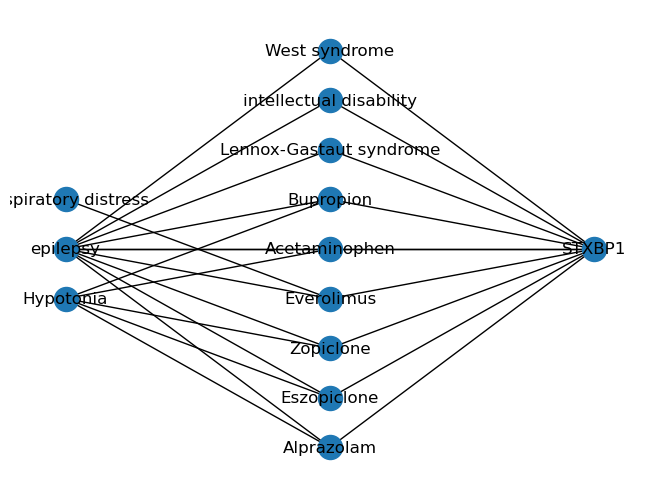

In [9]:
# Here's how to draw one result.  You can feed in a name or an id
draw_result(m, "STXBP1")

In [10]:
# Here's how to get EPC for one of these edges!
print_edge(m, "West syndrome", "STXBP1")

{
    "subject": "NCBIGene:6812",
    "object": "MONDO:0018097",
    "predicate": "biolink:genetically_associated_with",
    "sources": [
        {
            "resource_id": "infores:pharos",
            "resource_role": "aggregator_knowledge_source",
            "upstream_resource_ids": []
        },
        {
            "resource_id": "infores:disgenet",
            "resource_role": "primary_knowledge_source",
            "upstream_resource_ids": []
        },
        {
            "resource_id": "infores:aragorn",
            "resource_role": "aggregator_knowledge_source",
            "upstream_resource_ids": [
                "infores:answer-coalesce"
            ]
        }
    ],
    "attributes": []
}


In [11]:
### Everything after this is an example where we get the side effects for haliperidol and use that as input
### But it can be ignored for today!  And probably doesn't work with the changes to the above!!!

In [110]:
# Lets get some phenotypes
cypher = """match (a:`biolink:SmallMolecule` {id:"CHEBI:5613"})-[x:`biolink:has_adverse_event`]->(b:`biolink:DiseaseOrPhenotypicFeature`) 
where not (a)-[:`biolink:treats`]->(b)
and b.id starts with "HP"
return b.id, b.name, x.FAERS_llr as llr order by llr desc"""
robocypher = "https://automat.renci.org/robokopkg/cypher"
response = requests.post(robocypher, json = {"query": cypher} )

In [111]:
response.status_code

200

In [112]:
hps = [ r["row"][0] for r in response.json()["results"][0]["data"] ]
names = [ r["row"][1] for r in response.json()["results"][0]["data"] ]

In [113]:
len(hps)

126

In [118]:
hplist = hps[:10]
hpnames = names[:10]
for hpn in hpnames:
    print(hpn)

Abnormality of extrapyramidal motor function
Akathisia
Rigidity
Agitation
Prolonged QT interval
Auditory hallucination
Delusion
Arthralgia
Excessive daytime somnolence
Pain


In [116]:
query = generate_phenotypes_to_gene(hplist)
response = requests.post( ARS_CI_SUBMIT, json = query )
print(response.status_code)
pk = response.json()["pk"]
print(pk)

201
4a010ad3-a797-4f0a-a8e6-2be447404b77


In [117]:
r = retrieve_ars_results(pk,ars_url = ARS)
m = r["ara-aragorn"]
print_results(m)

0 HTR2A
direct path?
['biolink:Disease']
['biolink:ChemicalEntity']
1 SLC6A4
['biolink:Disease']
['biolink:ChemicalEntity']
2 ADRA2A
['biolink:ChemicalEntity']
3 HTR7
direct path?
['biolink:Disease']
['biolink:ChemicalEntity']
4 ADRA2B
['biolink:ChemicalEntity']
5 DRD4
['biolink:Disease']
['biolink:ChemicalEntity']
6 HTR6
['biolink:ChemicalEntity']
7 CYP2D6
direct path?
['biolink:Disease']
['biolink:ChemicalEntity']
8 ADA1B_RAT Alpha-1B adrenergic receptor (sprot)
['biolink:ChemicalEntity']
9 HTR1B
['biolink:Disease']
['biolink:ChemicalEntity']
10 ABCB11
['biolink:ChemicalEntity']
11 Adra1a
['biolink:ChemicalEntity']
12 SIGMAR1
['biolink:ChemicalEntity']
13 HTR1D
['biolink:ChemicalEntity']
14 Htr1a
['biolink:ChemicalEntity']
15 DRD3
direct path?
['biolink:Disease']
['biolink:ChemicalEntity']
16 HRH2
['biolink:ChemicalEntity']
17 CASP3
['biolink:ChemicalEntity']
18 CYP3A4
['biolink:ChemicalEntity']
19 DRD2
direct path?
['biolink:Disease']
['biolink:ChemicalEntity']
20 Htr2a
['biolink:Ch

In [73]:
hplist = hps[:30]
query = generate_phenotypes_to_gene(hplist)
response = requests.post( f"https://aragorn.renci.org/aragorn/query", json = query )
print(response.status_code)

200


In [74]:
print_results(response.json())

0 HTR2A
direct path?
['biolink:Disease']
['biolink:ChemicalEntity']
1 HTR2C
['biolink:Disease']
['biolink:ChemicalEntity']
2 ADRA2A
['biolink:Disease']
['biolink:ChemicalEntity']
3 SLC6A4
['biolink:Disease']
['biolink:ChemicalEntity']
4 ADRA2B
['biolink:ChemicalEntity']
5 DRD4
['biolink:Disease']
['biolink:ChemicalEntity']
6 HTR6
['biolink:ChemicalEntity']
7 ABCB1
['biolink:Disease']
['biolink:ChemicalEntity']
8 ABCB11
['biolink:ChemicalEntity']
9 ADA1B_RAT Alpha-1B adrenergic receptor (sprot)
['biolink:ChemicalEntity']
10 CYP2D6
direct path?
['biolink:ChemicalEntity']
11 HTR7
['biolink:ChemicalEntity']
12 HTR1B
['biolink:Disease']
['biolink:ChemicalEntity']
13 SIGMAR1
['biolink:ChemicalEntity']
14 CYP3A4
['biolink:ChemicalEntity']
15 Adra1a
['biolink:ChemicalEntity']
16 CACNA1C
['biolink:Disease']
['biolink:ChemicalEntity']
17 CDC20
['biolink:ChemicalEntity']
18 DRD1
['biolink:Disease']
['biolink:ChemicalEntity']
19 DRD2
direct path?
['biolink:Disease']
['biolink:ChemicalEntity']
20 H